In [1]:
!pip install mne
!pip install mne-icalabel
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.7 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA
from mne_icalabel import label_components
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Constants
FS = 128  # Sampling frequency
METADATA_COLUMNS =  [
    'EEG.Counter', 'EEG.Interpolated', 'EEG.RawCq', 'EEG.Battery',
    'EEG.BatteryPercent', 'EEG.MarkerHardware'
]

print("Libraries imported and constants initialized.")

Libraries imported and constants initialized.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import re
import pandas as pd

# Function to load and preprocess each participant's EEG CSV individually
def load_dataset_file_by_file(root_folder):
    dataset = []  # List of tuples: (dataframe, label, participant_id)

    for letter_folder in sorted(os.listdir(root_folder)):  # Optional: sort for consistency
        letter_path = os.path.join(root_folder, letter_folder)
        if not os.path.isdir(letter_path):
            print(f"Skipping {letter_path} (not a directory)")
            continue

        print(f"Processing letter folder: {letter_folder}")
        label = letter_folder  # Use folder name as label

        for file in os.listdir(letter_path):
            file_path = os.path.join(letter_path, file)
            if not os.path.isfile(file_path) or not file.endswith('.csv'):
                print(f"  Skipping {file} (not a .csv file)")
                continue

            print(f"  Reading participant file: {file}")
            try:
                df = pd.read_csv(file_path, skiprows=1)

                # Extract participant name using regex
                match = re.match(r'(par\.\d+)', file)
                participant_name = match.group(0) if match else "unknown"

                # Append as a tuple: (dataframe, label, participant_id)
                dataset.append((df, label, participant_name))
            except Exception as e:
                print(f"  Error reading {file_path}: {e}")
                continue

    return dataset

# Example usage
ROOT_FOLDER = "/content/drive/MyDrive/احرف"
dataset = load_dataset_file_by_file(ROOT_FOLDER)

# Check an example
print(f"\nTotal samples loaded: {len(dataset)}")
print("Example entry:")
df_sample, label_sample, participant_sample = dataset[0]
print(f"Participant: {participant_sample}, Label: {label_sample}")
print(df_sample.head())


  Reading participant file: par.6 ظاء_EPOCX_194172_2023.09.17T00.05.00+03.00.md.csv
  Reading participant file: par.19 ظاء_EPOCX_194172_2023.09.13T00.11.00+03.00.md.csv
  Reading participant file: par.28 ظاء_EPOCX_194172_2023.09.18T18.56.16+03.00.md.csv
  Reading participant file: par.29 ظاء_EPOCX_194172_2023.09.17T18.15.14+03.00.md.csv
  Reading participant file: par.3 ظاء_EPOCX_194172_2023.09.13T09.48.26+03.00.md.csv
  Reading participant file: par.23 ظاء_EPOCX_194172_2023.09.14T00.04.50+03.00.md.csv
  Reading participant file: par.18 ظاء_EPOCX_194172_2023.09.17T12.15.10+03.00.md.csv
  Reading participant file: par.4 ظاء_EPOCX_194172_2023.09.16T22.14.32+03.00.md.csv
  Reading participant file: par.10 ظاء_EPOCX_194172_2023.09.12T11.20.16+03.00.md.csv
  Reading participant file: par.17 ظاء_EPOCX_194172_2023.09.14T13.38.15+03.00.md.csv
  Reading participant file: par.15 ظاء_EPOCX_194172_2023.11.29T12.34.22+03.00.md.csv
  Reading participant file: par.22 ظاء_EPOCX_194172_2023.12.04T12.42

In [5]:
# Metadata columns to exclude from EEG signal channels
METADATA_COLUMNS = ['Time', 'Event Id', 'Event Date', 'Event Duration', 'Event Description']

# Function to validate EEG data for a single DataFrame
def validate_eeg_data(df):
    # Keep only EEG channels (not metadata)
    valid_columns = [col for col in df.columns if col.startswith('EEG.') and col not in METADATA_COLUMNS]

    if not valid_columns:
        print("  ❌ No valid EEG signal columns identified. Skipping this DataFrame.")
        return None, None

    print(f"  ✅ Validating data with shape: {df.shape}")
    return df[valid_columns].copy(), valid_columns

# Function to validate all entries in the dataset
def validate_all_eeg_data(dataset):
    validated_dataset = []           # Will store (cleaned_df, label, participant)
    valid_columns_map = {}           # Optional: track valid columns per participant
    skipped = 0

    for idx, (df, label, participant) in enumerate(dataset):
        print(f"\n🔍 Processing sample {idx + 1}/{len(dataset)} - Participant: {participant}, Label: {label}")
        validated_df, valid_columns = validate_eeg_data(df)

        if validated_df is not None:
            validated_dataset.append((validated_df, label, participant))
            valid_columns_map[participant] = valid_columns
        else:
            print(f"  ⚠️ Skipping sample from {participant}")
            skipped += 1

    print(f"\n✅ EEG validation complete. Valid samples: {len(validated_dataset)}, Skipped: {skipped}")
    return validated_dataset, valid_columns_map

# Run validation
validated_dataset, valid_columns_map = validate_all_eeg_data(dataset)

# Optional: Preview
df_example, label_example, participant_example = validated_dataset[0]
print(f"\n👤 Participant: {participant_example}, 🏷️ Label: {label_example}, 📐 EEG shape: {df_example.shape}")



🔍 Processing sample 1/931 - Participant: par.28, Label: ء
  ✅ Validating data with shape: (1419, 68)

🔍 Processing sample 2/931 - Participant: par.29, Label: ء
  ✅ Validating data with shape: (1370, 68)

🔍 Processing sample 3/931 - Participant: par.6, Label: ء
  ✅ Validating data with shape: (1414, 68)

🔍 Processing sample 4/931 - Participant: par.14, Label: ء
  ✅ Validating data with shape: (1374, 68)

🔍 Processing sample 5/931 - Participant: par.27, Label: ء
  ✅ Validating data with shape: (1379, 68)

🔍 Processing sample 6/931 - Participant: par.4, Label: ء
  ✅ Validating data with shape: (1371, 68)

🔍 Processing sample 7/931 - Participant: par.17, Label: ء
  ✅ Validating data with shape: (1369, 68)

🔍 Processing sample 8/931 - Participant: par.25, Label: ء
  ✅ Validating data with shape: (1346, 68)

🔍 Processing sample 9/931 - Participant: par.24, Label: ء
  ✅ Validating data with shape: (1380, 68)

🔍 Processing sample 10/931 - Participant: par.9, Label: ء
  ✅ Validating data with 

In [6]:
# ✅ Final list of channels to keep after removing EEG.O2 and EEG.FC6
DESIRED_EEG_CHANNELS = [
    'EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7', 'EEG.P7',
    'EEG.O1', 'EEG.P8', 'EEG.T8', 'EEG.F4', 'EEG.F8', 'EEG.AF4'
]

def clean_validated_dataset(validated_dataset):
    cleaned_dataset = []

    for idx, (df, label, participant) in enumerate(validated_dataset):
        print(f"\n🧹 Cleaning sample {idx + 1}/{len(validated_dataset)} - Participant: {participant}, Label: {label}")

        # Select only the desired EEG channels (intersection in case some are missing)
        available_channels = [ch for ch in DESIRED_EEG_CHANNELS if ch in df.columns]
        df_cleaned = df[available_channels].copy()

        removed_channels = [ch for ch in ['EEG.O2', 'EEG.FC6'] if ch in df.columns]
        print(f"  Removed channels: {removed_channels}")
        print(f"  Shape after cleaning: {df_cleaned.shape}")

        cleaned_dataset.append((df_cleaned, label, participant))

    print(f"\n✅ Finished cleaning all EEG samples. Total cleaned samples: {len(cleaned_dataset)}")
    return cleaned_dataset


# Run the cleaning step
cleaned_dataset = clean_validated_dataset(validated_dataset)

# Example check
df_clean, label_clean, participant_clean = cleaned_dataset[0]
print(f"\n👤 Participant: {participant_clean}, 🏷️ Label: {label_clean}, 📐 Cleaned EEG shape: {df_clean.shape}")



🧹 Cleaning sample 1/928 - Participant: par.28, Label: ء
  Removed channels: ['EEG.O2', 'EEG.FC6']
  Shape after cleaning: (1419, 12)

🧹 Cleaning sample 2/928 - Participant: par.29, Label: ء
  Removed channels: ['EEG.O2', 'EEG.FC6']
  Shape after cleaning: (1370, 12)

🧹 Cleaning sample 3/928 - Participant: par.6, Label: ء
  Removed channels: ['EEG.O2', 'EEG.FC6']
  Shape after cleaning: (1414, 12)

🧹 Cleaning sample 4/928 - Participant: par.14, Label: ء
  Removed channels: ['EEG.O2', 'EEG.FC6']
  Shape after cleaning: (1374, 12)

🧹 Cleaning sample 5/928 - Participant: par.27, Label: ء
  Removed channels: ['EEG.O2', 'EEG.FC6']
  Shape after cleaning: (1379, 12)

🧹 Cleaning sample 6/928 - Participant: par.4, Label: ء
  Removed channels: ['EEG.O2', 'EEG.FC6']
  Shape after cleaning: (1371, 12)

🧹 Cleaning sample 7/928 - Participant: par.17, Label: ء
  Removed channels: ['EEG.O2', 'EEG.FC6']
  Shape after cleaning: (1369, 12)

🧹 Cleaning sample 8/928 - Participant: par.25, Label: ء
  Remov

In [7]:
import mne

FS = 128  # Set your actual sampling frequency here

# Function to create an MNE Raw object
def create_raw_object(eeg_data, sfreq=FS):
    data = eeg_data.to_numpy().T  # Transpose to shape (n_channels, n_times)
    ch_names = eeg_data.columns.tolist()
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=['eeg'] * len(ch_names))
    raw = mne.io.RawArray(data, info, verbose=False)
    return raw

# Function to rename EEG channels for standard montage compatibility
def rename_eeg_channels(raw_object):
    rename_dict = {
        'EEG.AF3': 'AF3', 'EEG.AF4': 'AF4', 'EEG.F7': 'F7',
        'EEG.F3': 'F3', 'EEG.FC5': 'FC5', 'EEG.T7': 'T7',
        'EEG.P7': 'P7', 'EEG.O1': 'O1', 'EEG.P8': 'P8',
        'EEG.T8': 'T8', 'EEG.F4': 'F4', 'EEG.F8': 'F8'
    }
    raw_object.rename_channels(rename_dict)
    return raw_object

# Create Raw objects for each cleaned entry (per participant)
raw_dataset = []  # Will store (raw_object, label, participant)

for idx, (df_clean, label, participant) in enumerate(cleaned_dataset):
    print(f"\n🧠 Creating Raw object {idx + 1}/{len(cleaned_dataset)} - Participant: {participant}, Label: {label}")

    try:
        raw = create_raw_object(df_clean)
        raw = rename_eeg_channels(raw)
        raw_dataset.append((raw, label, participant))
        print("  ✅ Successfully created and renamed Raw object.")
    except Exception as e:
        print(f"  ❌ Failed to create Raw object for {participant}, label {label}: {e}")



🧠 Creating Raw object 1/928 - Participant: par.28, Label: ء
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 2/928 - Participant: par.29, Label: ء
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 3/928 - Participant: par.6, Label: ء
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 4/928 - Participant: par.14, Label: ء
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 5/928 - Participant: par.27, Label: ء
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 6/928 - Participant: par.4, Label: ء
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 7/928 - Participant: par.17, Label: ء
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 8/928 - Participant: par.25, Label: ء
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 9/928 - Participant: par.24, Label: ء
  ✅ Successfully created and renamed Raw object.

🧠 Creating 

In [8]:
from mne.preprocessing import ICA
from mne_icalabel import label_components
import numpy as np

# Apply filters and referencing to a Raw object
def apply_filters_and_reference(raw):
    raw.notch_filter(freqs=50.0, verbose=False)
    raw.filter(l_freq=1.0, h_freq=50.0, verbose=False)
    raw.set_eeg_reference('average', projection=True, verbose=False)
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, verbose=False)
    print("  ✅ Filters and referencing applied.")
    return raw

# Perform ICA and clean artifacts for a Raw object
def perform_ica(raw, brain_threshold=0.5):
    ica = ICA(method='infomax', fit_params={'extended': True}, n_components=12, max_iter=1000, random_state=42)
    ica.fit(raw, verbose=False)

    ic_labels = label_components(raw, ica, method="iclabel")

    non_brain_components = [
        idx for idx, (label, prob) in enumerate(zip(ic_labels['labels'], ic_labels['y_pred_proba']))
        if label != 'brain' or prob < brain_threshold
    ]

    ica.exclude = non_brain_components
    raw_cleaned = ica.apply(raw.copy(), verbose=False)

    print(f"  ✅ ICA completed. Excluded components: {non_brain_components}")
    return raw_cleaned

# Check and clean NaN/Inf values from Raw data
def clean_nan_inf(raw):
    data = raw.get_data()
    if np.isnan(data).any() or np.isinf(data).any():
        print("  ⚠️ Detected NaN or Inf values.")
        for i in range(data.shape[0]):
            channel_data = data[i, :]
            channel_mean = np.nanmean(channel_data)
            channel_data[np.isnan(channel_data)] = channel_mean
            channel_data[np.isinf(channel_data)] = channel_mean
            data[i, :] = channel_data
        print("  ✅ NaN/Inf values replaced with channel means.")
    else:
        print("  ✅ No NaN or Inf values detected.")
    raw._data = data
    return raw

# Final cleaned raw dataset: list of (raw_object, label, participant)
cleaned_raw_dataset = []

for idx, (raw_object, label, participant) in enumerate(raw_dataset):
    print(f"\n🧪 Processing sample {idx + 1}/{len(raw_dataset)} - Participant: {participant}, Label: {label}")
    try:
        raw = apply_filters_and_reference(raw_object)
        raw = clean_nan_inf(raw)
        raw = perform_ica(raw)
        cleaned_raw_dataset.append((raw, label, participant))
        print(f"  ✅ Successfully processed sample for {participant} ({label})")
    except Exception as e:
        print(f"  ❌ Failed to process sample for {participant} ({label}): {e}")


  ✅ ICA completed. Excluded components: [5, 7, 8, 9]
  ✅ Successfully processed sample for par.22 (ك)

🧪 Processing sample 712/928 - Participant: par.16, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3]
  ✅ Successfully processed sample for par.16 (ك)

🧪 Processing sample 713/928 - Participant: par.13, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 5, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.13 (ك)

🧪 Processing sample 714/928 - Participant: par.1, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 10]
  ✅ Successfully processed sample for par.1 (ك)

🧪 Processing sample 715/928 - Participant: par.11, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 10, 11]
  ✅ Successfully processed sample for par.11 (ك)

🧪 Processing sample 716/928 - Participant: par.20, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 8, 10, 11]
  ✅ Successfully processed sample for par.20 (ك)

🧪 Processing sample 717/928 - Participant: par.12, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.12 (ك)

🧪 Processing sample 718/928 - Participant: par.8, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 11]
  ✅ Successfully processed sample for par.8 (ك)

🧪 Processing sample 719/928 - Participant: par.2, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.2 (ك)

🧪 Processing sample 720/928 - Participant: par.19, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 5, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.19 (ل)

🧪 Processing sample 721/928 - Participant: par.17, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 5, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.17 (ل)

🧪 Processing sample 722/928 - Participant: par.29, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5]
  ✅ Successfully processed sample for par.29 (ل)

🧪 Processing sample 723/928 - Participant: par.6, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 11]
  ✅ Successfully processed sample for par.6 (ل)

🧪 Processing sample 724/928 - Participant: par.5, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.5 (ل)

🧪 Processing sample 725/928 - Participant: par.27, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 5, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.27 (ل)

🧪 Processing sample 726/928 - Participant: par.25, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 8, 9, 10]
  ✅ Successfully processed sample for par.25 (ل)

🧪 Processing sample 727/928 - Participant: par.18, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 9, 10, 11]
  ✅ Successfully processed sample for par.18 (ل)

🧪 Processing sample 728/928 - Participant: par.28, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 6, 10, 11]
  ✅ Successfully processed sample for par.28 (ل)

🧪 Processing sample 729/928 - Participant: par.7, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.7 (ل)

🧪 Processing sample 730/928 - Participant: par.9, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2]
  ✅ Successfully processed sample for par.9 (ل)

🧪 Processing sample 731/928 - Participant: par.24, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.24 (ل)

🧪 Processing sample 732/928 - Participant: par.10, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 7, 9, 10]
  ✅ Successfully processed sample for par.10 (ل)

🧪 Processing sample 733/928 - Participant: par.3, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 6, 8, 10]
  ✅ Successfully processed sample for par.3 (ل)

🧪 Processing sample 734/928 - Participant: par.4, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.4 (ل)

🧪 Processing sample 735/928 - Participant: par.30, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.30 (ل)

🧪 Processing sample 736/928 - Participant: par.21, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 9]
  ✅ Successfully processed sample for par.21 (ل)

🧪 Processing sample 737/928 - Participant: par.23, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.23 (ل)

🧪 Processing sample 738/928 - Participant: par.14, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.14 (ل)

🧪 Processing sample 739/928 - Participant: par.26, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 5, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.26 (ل)

🧪 Processing sample 740/928 - Participant: par.15, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 8, 10]
  ✅ Successfully processed sample for par.15 (ل)

🧪 Processing sample 741/928 - Participant: par.22, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 7, 11]
  ✅ Successfully processed sample for par.22 (ل)

🧪 Processing sample 742/928 - Participant: par.20, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 8, 10, 11]
  ✅ Successfully processed sample for par.20 (ل)

🧪 Processing sample 743/928 - Participant: par.13, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 5, 8, 10, 11]
  ✅ Successfully processed sample for par.13 (ل)

🧪 Processing sample 744/928 - Participant: par.12, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [9, 10]
  ✅ Successfully processed sample for par.12 (ل)

🧪 Processing sample 745/928 - Participant: par.16, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 9]
  ✅ Successfully processed sample for par.16 (ل)

🧪 Processing sample 746/928 - Participant: par.11, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.11 (ل)

🧪 Processing sample 747/928 - Participant: par.1, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.1 (ل)

🧪 Processing sample 748/928 - Participant: par.8, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 6, 9, 10]
  ✅ Successfully processed sample for par.8 (ل)

🧪 Processing sample 749/928 - Participant: par.2, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 9]
  ✅ Successfully processed sample for par.2 (ل)

🧪 Processing sample 750/928 - Participant: par.5, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 6, 9]
  ✅ Successfully processed sample for par.5 (م)

🧪 Processing sample 751/928 - Participant: par.29, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 9]
  ✅ Successfully processed sample for par.29 (م)

🧪 Processing sample 752/928 - Participant: par.6, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 9, 11]
  ✅ Successfully processed sample for par.6 (م)

🧪 Processing sample 753/928 - Participant: par.28, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 6, 8, 9, 11]
  ✅ Successfully processed sample for par.28 (م)

🧪 Processing sample 754/928 - Participant: par.23, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 5, 6, 8, 9, 11]
  ✅ Successfully processed sample for par.23 (م)

🧪 Processing sample 755/928 - Participant: par.4, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.4 (م)

🧪 Processing sample 756/928 - Participant: par.19, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.19 (م)

🧪 Processing sample 757/928 - Participant: par.7, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.7 (م)

🧪 Processing sample 758/928 - Participant: par.30, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 5, 6, 8, 10, 11]
  ✅ Successfully processed sample for par.30 (م)

🧪 Processing sample 759/928 - Participant: par.18, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.18 (م)

🧪 Processing sample 760/928 - Participant: par.3, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.3 (م)

🧪 Processing sample 761/928 - Participant: par.14, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 5, 8, 9, 10]
  ✅ Successfully processed sample for par.14 (م)

🧪 Processing sample 762/928 - Participant: par.17, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 5, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.17 (م)

🧪 Processing sample 763/928 - Participant: par.27, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.27 (م)

🧪 Processing sample 764/928 - Participant: par.9, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 9, 11]
  ✅ Successfully processed sample for par.9 (م)

🧪 Processing sample 765/928 - Participant: par.21, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.21 (م)

🧪 Processing sample 766/928 - Participant: par.24, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 5, 6, 8, 11]
  ✅ Successfully processed sample for par.24 (م)

🧪 Processing sample 767/928 - Participant: par.25, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.25 (م)

🧪 Processing sample 768/928 - Participant: par.10, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 8]
  ✅ Successfully processed sample for par.10 (م)

🧪 Processing sample 769/928 - Participant: par.26, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.26 (م)

🧪 Processing sample 770/928 - Participant: par.15, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 6, 8, 11]
  ✅ Successfully processed sample for par.15 (م)

🧪 Processing sample 771/928 - Participant: par.20, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 10, 11]
  ✅ Successfully processed sample for par.20 (م)

🧪 Processing sample 772/928 - Participant: par.16, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 8]
  ✅ Successfully processed sample for par.16 (م)

🧪 Processing sample 773/928 - Participant: par.11, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.11 (م)

🧪 Processing sample 774/928 - Participant: par.12, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.12 (م)

🧪 Processing sample 775/928 - Participant: par.13, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 5, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.13 (م)

🧪 Processing sample 776/928 - Participant: par.1, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.1 (م)

🧪 Processing sample 777/928 - Participant: par.8, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.8 (م)

🧪 Processing sample 778/928 - Participant: par.22, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4]
  ✅ Successfully processed sample for par.22 (م)

🧪 Processing sample 779/928 - Participant: par.2, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 10]
  ✅ Successfully processed sample for par.2 (م)

🧪 Processing sample 780/928 - Participant: par.3, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 7, 9, 11]
  ✅ Successfully processed sample for par.3 (ن)

🧪 Processing sample 781/928 - Participant: par.23, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.23 (ن)

🧪 Processing sample 782/928 - Participant: par.30, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 6, 7, 9, 11]
  ✅ Successfully processed sample for par.30 (ن)

🧪 Processing sample 783/928 - Participant: par.14, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.14 (ن)

🧪 Processing sample 784/928 - Participant: par.27, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 7, 10]
  ✅ Successfully processed sample for par.27 (ن)

🧪 Processing sample 785/928 - Participant: par.9, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.9 (ن)

🧪 Processing sample 786/928 - Participant: par.6, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [9, 10, 11]
  ✅ Successfully processed sample for par.6 (ن)

🧪 Processing sample 787/928 - Participant: par.4, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 7, 9, 11]
  ✅ Successfully processed sample for par.4 (ن)

🧪 Processing sample 788/928 - Participant: par.19, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 10, 11]
  ✅ Successfully processed sample for par.19 (ن)

🧪 Processing sample 789/928 - Participant: par.18, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 10]
  ✅ Successfully processed sample for par.18 (ن)

🧪 Processing sample 790/928 - Participant: par.29, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 10]
  ✅ Successfully processed sample for par.29 (ن)

🧪 Processing sample 791/928 - Participant: par.7, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 5, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.7 (ن)

🧪 Processing sample 792/928 - Participant: par.17, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 5, 6, 8, 9, 11]
  ✅ Successfully processed sample for par.17 (ن)

🧪 Processing sample 793/928 - Participant: par.21, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 6, 9, 10, 11]
  ✅ Successfully processed sample for par.21 (ن)

🧪 Processing sample 794/928 - Participant: par.28, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 5, 7, 9, 11]
  ✅ Successfully processed sample for par.28 (ن)

🧪 Processing sample 795/928 - Participant: par.26, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 5, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.26 (ن)

🧪 Processing sample 796/928 - Participant: par.25, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 6, 9, 10]
  ✅ Successfully processed sample for par.25 (ن)

🧪 Processing sample 797/928 - Participant: par.5, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.5 (ن)

🧪 Processing sample 798/928 - Participant: par.10, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 6]
  ✅ Successfully processed sample for par.10 (ن)

🧪 Processing sample 799/928 - Participant: par.24, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 5, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.24 (ن)

🧪 Processing sample 800/928 - Participant: par.15, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 6, 10, 11]
  ✅ Successfully processed sample for par.15 (ن)

🧪 Processing sample 801/928 - Participant: par.22, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 8, 9]
  ✅ Successfully processed sample for par.22 (ن)

🧪 Processing sample 802/928 - Participant: par.1, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.1 (ن)

🧪 Processing sample 803/928 - Participant: par.13, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 5, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.13 (ن)

🧪 Processing sample 804/928 - Participant: par.12, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.12 (ن)

🧪 Processing sample 805/928 - Participant: par.20, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 6, 8]
  ✅ Successfully processed sample for par.20 (ن)

🧪 Processing sample 806/928 - Participant: par.16, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 8, 10, 11]
  ✅ Successfully processed sample for par.16 (ن)

🧪 Processing sample 807/928 - Participant: par.11, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 7, 8]
  ✅ Successfully processed sample for par.11 (ن)

🧪 Processing sample 808/928 - Participant: par.8, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.8 (ن)

🧪 Processing sample 809/928 - Participant: par.2, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.2 (ن)

🧪 Processing sample 810/928 - Participant: par.27, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 6, 8]
  ✅ Successfully processed sample for par.27 (ه)

🧪 Processing sample 811/928 - Participant: par.24, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.24 (ه)

🧪 Processing sample 812/928 - Participant: par.26, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 6, 10, 11]
  ✅ Successfully processed sample for par.26 (ه)

🧪 Processing sample 813/928 - Participant: par.23, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 9, 10]
  ✅ Successfully processed sample for par.23 (ه)

🧪 Processing sample 814/928 - Participant: unknown, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10]
  ✅ Successfully processed sample for unknown (ه)

🧪 Processing sample 815/928 - Participant: par.5, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 11]
  ✅ Successfully processed sample for par.5 (ه)

🧪 Processing sample 816/928 - Participant: par.3, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 5, 6, 7, 8, 9]
  ✅ Successfully processed sample for par.3 (ه)

🧪 Processing sample 817/928 - Participant: par.13, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 5, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.13 (ه)

🧪 Processing sample 818/928 - Participant: par.2, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.2 (ه)

🧪 Processing sample 819/928 - Participant: par.25, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.25 (ه)

🧪 Processing sample 820/928 - Participant: par.21, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.21 (ه)

🧪 Processing sample 821/928 - Participant: par.6, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.6 (ه)

🧪 Processing sample 822/928 - Participant: par.22, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 9, 10, 11]
  ✅ Successfully processed sample for par.22 (ه)

🧪 Processing sample 823/928 - Participant: par.8, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 5, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.8 (ه)

🧪 Processing sample 824/928 - Participant: par.17, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 5, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.17 (ه)

🧪 Processing sample 825/928 - Participant: par.4, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 6, 10, 11]
  ✅ Successfully processed sample for par.4 (ه)

🧪 Processing sample 826/928 - Participant: par.19, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.19 (ه)

🧪 Processing sample 827/928 - Participant: par.16, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.16 (ه)

🧪 Processing sample 828/928 - Participant: par.28, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 7, 10, 11]
  ✅ Successfully processed sample for par.28 (ه)

🧪 Processing sample 829/928 - Participant: par.9, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:7: RuntimeWarning: filter_length (845) is longer than the signal (688), distortion is likely. Reduce filter length or filter a longer signal.
  raw.notch_filter(freqs=50.0, verbose=False)
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 5, 7, 10]
  ✅ Successfully processed sample for par.9 (ه)

🧪 Processing sample 830/928 - Participant: par.14, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 6, 8, 10]
  ✅ Successfully processed sample for par.14 (ه)

🧪 Processing sample 831/928 - Participant: par.20, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 9]
  ✅ Successfully processed sample for par.20 (ه)

🧪 Processing sample 832/928 - Participant: par.10, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.10 (ه)

🧪 Processing sample 833/928 - Participant: par.11, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.11 (ه)

🧪 Processing sample 834/928 - Participant: par.15, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 10]
  ✅ Successfully processed sample for par.15 (ه)

🧪 Processing sample 835/928 - Participant: par.18, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 8, 9, 10]
  ✅ Successfully processed sample for par.18 (ه)

🧪 Processing sample 836/928 - Participant: par.1, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 7, 10, 11]
  ✅ Successfully processed sample for par.1 (ه)

🧪 Processing sample 837/928 - Participant: par.12, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 5, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.12 (ه)

🧪 Processing sample 838/928 - Participant: par.7, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 8, 9, 11]
  ✅ Successfully processed sample for par.7 (ه)

🧪 Processing sample 839/928 - Participant: unknown, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for unknown (ه)

🧪 Processing sample 840/928 - Participant: par.5, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 6, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.5 (و)

🧪 Processing sample 841/928 - Participant: par.21, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 5, 6, 10, 11]
  ✅ Successfully processed sample for par.21 (و)

🧪 Processing sample 842/928 - Participant: par.30, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 6, 8, 10, 11]
  ✅ Successfully processed sample for par.30 (و)

🧪 Processing sample 843/928 - Participant: par.6, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [9]
  ✅ Successfully processed sample for par.6 (و)

🧪 Processing sample 844/928 - Participant: par.9, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.9 (و)

🧪 Processing sample 845/928 - Participant: par.26, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.26 (و)

🧪 Processing sample 846/928 - Participant: par.25, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.25 (و)

🧪 Processing sample 847/928 - Participant: par.17, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 5, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.17 (و)

🧪 Processing sample 848/928 - Participant: par.28, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 5, 7, 10, 11]
  ✅ Successfully processed sample for par.28 (و)

🧪 Processing sample 849/928 - Participant: par.14, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.14 (و)

🧪 Processing sample 850/928 - Participant: par.29, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 7, 11]
  ✅ Successfully processed sample for par.29 (و)

🧪 Processing sample 851/928 - Participant: par.19, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 10, 11]
  ✅ Successfully processed sample for par.19 (و)

🧪 Processing sample 852/928 - Participant: par.18, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 7, 11]
  ✅ Successfully processed sample for par.18 (و)

🧪 Processing sample 853/928 - Participant: par.7, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 5, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.7 (و)

🧪 Processing sample 854/928 - Participant: par.27, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.27 (و)

🧪 Processing sample 855/928 - Participant: par.4, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 5, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.4 (و)

🧪 Processing sample 856/928 - Participant: par.23, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.23 (و)

🧪 Processing sample 857/928 - Participant: par.24, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.24 (و)

🧪 Processing sample 858/928 - Participant: par.3, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 7, 10]
  ✅ Successfully processed sample for par.3 (و)

🧪 Processing sample 859/928 - Participant: par.10, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 6, 8, 9, 11]
  ✅ Successfully processed sample for par.10 (و)

🧪 Processing sample 860/928 - Participant: par.15, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.15 (و)

🧪 Processing sample 861/928 - Participant: par.22, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 9]
  ✅ Successfully processed sample for par.22 (و)

🧪 Processing sample 862/928 - Participant: par.16, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 7, 9, 11]
  ✅ Successfully processed sample for par.16 (و)

🧪 Processing sample 863/928 - Participant: par.11, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.11 (و)

🧪 Processing sample 864/928 - Participant: par.13, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 9, 10]
  ✅ Successfully processed sample for par.13 (و)

🧪 Processing sample 865/928 - Participant: par.20, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 8, 10]
  ✅ Successfully processed sample for par.20 (و)

🧪 Processing sample 866/928 - Participant: par.12, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.12 (و)

🧪 Processing sample 867/928 - Participant: par.1, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.1 (و)

🧪 Processing sample 868/928 - Participant: par.8, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 10, 11]
  ✅ Successfully processed sample for par.8 (و)

🧪 Processing sample 869/928 - Participant: par.2, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 5, 7, 8, 11]
  ✅ Successfully processed sample for par.2 (و)

🧪 Processing sample 870/928 - Participant: par.21, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 11]
  ✅ Successfully processed sample for par.21 (ى)

🧪 Processing sample 871/928 - Participant: par.23, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.23 (ى)

🧪 Processing sample 872/928 - Participant: par.9, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.9 (ى)

🧪 Processing sample 873/928 - Participant: par.25, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 8, 10, 11]
  ✅ Successfully processed sample for par.25 (ى)

🧪 Processing sample 874/928 - Participant: par.27, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 5, 7, 8, 10]
  ✅ Successfully processed sample for par.27 (ى)

🧪 Processing sample 875/928 - Participant: par.30, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 5, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.30 (ى)

🧪 Processing sample 876/928 - Participant: par.10, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 8, 9, 10]
  ✅ Successfully processed sample for par.10 (ى)

🧪 Processing sample 877/928 - Participant: par.14, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.14 (ى)

🧪 Processing sample 878/928 - Participant: par.26, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.26 (ى)

🧪 Processing sample 879/928 - Participant: par.6, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [9, 11]
  ✅ Successfully processed sample for par.6 (ى)

🧪 Processing sample 880/928 - Participant: par.4, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.4 (ى)

🧪 Processing sample 881/928 - Participant: par.24, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 5, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.24 (ى)

🧪 Processing sample 882/928 - Participant: par.17, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 6, 8, 11]
  ✅ Successfully processed sample for par.17 (ى)

🧪 Processing sample 883/928 - Participant: par.28, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.28 (ى)

🧪 Processing sample 884/928 - Participant: par.18, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 5, 6, 9, 10]
  ✅ Successfully processed sample for par.18 (ى)

🧪 Processing sample 885/928 - Participant: par.29, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 6]
  ✅ Successfully processed sample for par.29 (ى)

🧪 Processing sample 886/928 - Participant: par.7, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 5, 6, 8, 9, 11]
  ✅ Successfully processed sample for par.7 (ى)

🧪 Processing sample 887/928 - Participant: par.19, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 6, 9, 10, 11]
  ✅ Successfully processed sample for par.19 (ى)

🧪 Processing sample 888/928 - Participant: par.5, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 6]
  ✅ Successfully processed sample for par.5 (ى)

🧪 Processing sample 889/928 - Participant: par.3, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.3 (ى)

🧪 Processing sample 890/928 - Participant: par.15, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 9, 10, 11]
  ✅ Successfully processed sample for par.15 (ى)

🧪 Processing sample 891/928 - Participant: par.22, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 6, 7, 10]
  ✅ Successfully processed sample for par.22 (ى)

🧪 Processing sample 892/928 - Participant: par.1, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.1 (ى)

🧪 Processing sample 893/928 - Participant: par.12, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 5, 7, 10, 11]
  ✅ Successfully processed sample for par.12 (ى)

🧪 Processing sample 894/928 - Participant: par.20, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.20 (ى)

🧪 Processing sample 895/928 - Participant: par.11, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 6, 8, 10]
  ✅ Successfully processed sample for par.11 (ى)

🧪 Processing sample 896/928 - Participant: par.13, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 5, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.13 (ى)

🧪 Processing sample 897/928 - Participant: par.16, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 9]
  ✅ Successfully processed sample for par.16 (ى)

🧪 Processing sample 898/928 - Participant: par.8, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 9, 11]
  ✅ Successfully processed sample for par.8 (ى)

🧪 Processing sample 899/928 - Participant: par.2, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.2 (ى)

🧪 Processing sample 900/928 - Participant: par.20, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 6, 9, 10, 11]
  ✅ Successfully processed sample for par.20 (ي)

🧪 Processing sample 901/928 - Participant: par.22, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 5, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.22 (ي)

🧪 Processing sample 902/928 - Participant: par.23, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 5, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.23 (ي)

🧪 Processing sample 903/928 - Participant: par.6, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.6 (ي)

🧪 Processing sample 904/928 - Participant: par.9, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 7]
  ✅ Successfully processed sample for par.9 (ي)

🧪 Processing sample 905/928 - Participant: par.13, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 6, 7, 9]
  ✅ Successfully processed sample for par.13 (ي)

🧪 Processing sample 906/928 - Participant: par.16, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 5, 8, 10]
  ✅ Successfully processed sample for par.16 (ي)

🧪 Processing sample 907/928 - Participant: par.18, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 7, 10, 11]
  ✅ Successfully processed sample for par.18 (ي)

🧪 Processing sample 908/928 - Participant: par.28, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 9, 11]
  ✅ Successfully processed sample for par.28 (ي)

🧪 Processing sample 909/928 - Participant: par.4, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 6, 8, 10, 11]
  ✅ Successfully processed sample for par.4 (ي)

🧪 Processing sample 910/928 - Participant: par.8, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 5, 6, 8, 9, 11]
  ✅ Successfully processed sample for par.8 (ي)

🧪 Processing sample 911/928 - Participant: par.29, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 5, 8, 9, 11]
  ✅ Successfully processed sample for par.29 (ي)

🧪 Processing sample 912/928 - Participant: par.25, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.25 (ي)

🧪 Processing sample 913/928 - Participant: par.27, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.27 (ي)

🧪 Processing sample 914/928 - Participant: par.5, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 11]
  ✅ Successfully processed sample for par.5 (ي)

🧪 Processing sample 915/928 - Participant: par.17, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 9]
  ✅ Successfully processed sample for par.17 (ي)

🧪 Processing sample 916/928 - Participant: par.26, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 5, 6, 8, 9, 11]
  ✅ Successfully processed sample for par.26 (ي)

🧪 Processing sample 917/928 - Participant: par.3, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 8, 11]
  ✅ Successfully processed sample for par.3 (ي)

🧪 Processing sample 918/928 - Participant: par.24, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 7, 10]
  ✅ Successfully processed sample for par.24 (ي)

🧪 Processing sample 919/928 - Participant: par.14, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.14 (ي)

🧪 Processing sample 920/928 - Participant: par.21, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [9]
  ✅ Successfully processed sample for par.21 (ي)

🧪 Processing sample 921/928 - Participant: par.11, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 9, 10, 11]
  ✅ Successfully processed sample for par.11 (ي)

🧪 Processing sample 922/928 - Participant: par.10, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.10 (ي)

🧪 Processing sample 923/928 - Participant: par.1, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 5, 6, 8, 9]
  ✅ Successfully processed sample for par.1 (ي)

🧪 Processing sample 924/928 - Participant: par.19, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 6, 8, 9]
  ✅ Successfully processed sample for par.19 (ي)

🧪 Processing sample 925/928 - Participant: par.15, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 8, 10, 11]
  ✅ Successfully processed sample for par.15 (ي)

🧪 Processing sample 926/928 - Participant: par.12, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 6, 9, 10]
  ✅ Successfully processed sample for par.12 (ي)

🧪 Processing sample 927/928 - Participant: par.7, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 8, 9, 10]
  ✅ Successfully processed sample for par.7 (ي)

🧪 Processing sample 928/928 - Participant: par.2, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 6, 8, 9]
  ✅ Successfully processed sample for par.2 (ي)


In [9]:
# Interpolation and NaN handling for Raw objects after ICA and filtering
def interpolate_and_handle_nans(raw_cleaned):
    try:
        # Step 1: Interpolate bad channels (if any)
        if raw_cleaned.info['bads']:
            print(f"  ⚠️ Interpolating bad channels: {raw_cleaned.info['bads']}")
            raw_cleaned.interpolate_bads(reset_bads=True)
        else:
            print("  ✅ No bad channels to interpolate.")

        # Step 2: Extract EEG data into DataFrame
        eeg_data = pd.DataFrame(raw_cleaned.get_data().T, columns=raw_cleaned.ch_names)

        # Step 3: Interpolate NaN values in the EEG data
        if eeg_data.isna().sum().sum() > 0:
            print("  ⚠️ NaN values found. Performing interpolation...")
            eeg_data = eeg_data.interpolate(method='linear', axis=0)
            eeg_data = eeg_data.fillna(method='ffill').fillna(method='bfill')
        else:
            print("  ✅ No NaN values detected in EEG data.")

        # Step 4: Recreate Raw object with cleaned data
        raw_cleaned = mne.io.RawArray(eeg_data.T.to_numpy(), raw_cleaned.info)
        return raw_cleaned

    except Exception as e:
        print(f"  ❌ Error during interpolation and NaN handling: {e}")
        return raw_cleaned


# Final list of fully cleaned raw samples (after ICA + interpolation)
fully_cleaned_raw_dataset = []

for idx, (raw_object, label, participant) in enumerate(cleaned_raw_dataset):
    print(f"\n🧼 Interpolating + NaN Cleaning sample {idx + 1}/{len(cleaned_raw_dataset)} - Participant: {participant}, Label: {label}")

    try:
        cleaned_raw = interpolate_and_handle_nans(raw_object)
        fully_cleaned_raw_dataset.append((cleaned_raw, label, participant))
        print(f"  ✅ Successfully cleaned sample for {participant} ({label})")

    except Exception as e:
        print(f"  ❌ Failed to process sample for {participant} ({label}): {e}")


Streaming output truncated to the last 5000 lines.

🧼 Interpolating + NaN Cleaning sample 304/928 - Participant: par.5, Label: ذ
  ✅ No bad channels to interpolate.
  ✅ No NaN values detected in EEG data.
Creating RawArray with float64 data, n_channels=12, n_times=1419
    Range : 0 ... 1418 =      0.000 ...    11.078 secs
Ready.
  ✅ Successfully cleaned sample for par.5 (ذ)

🧼 Interpolating + NaN Cleaning sample 305/928 - Participant: par.10, Label: ذ
  ✅ No bad channels to interpolate.
  ✅ No NaN values detected in EEG data.
Creating RawArray with float64 data, n_channels=12, n_times=1381
    Range : 0 ... 1380 =      0.000 ...    10.781 secs
Ready.
  ✅ Successfully cleaned sample for par.10 (ذ)

🧼 Interpolating + NaN Cleaning sample 306/928 - Participant: par.7, Label: ذ
  ✅ No bad channels to interpolate.
  ✅ No NaN values detected in EEG data.
Creating RawArray with float64 data, n_channels=12, n_times=1379
    Range : 0 ... 1378 =      0.000 ...    10.766 secs
Ready.
  ✅ Successf

In [10]:
# Function to apply Z-score normalization to EEG data
def z_score_normalize_eeg_data(raw):
    """
    Normalize the EEG data in the Raw object using Z-score normalization
    (zero mean, unit variance) per channel.
    """
    eeg_data = raw.get_data()
    mean = np.mean(eeg_data, axis=1, keepdims=True)
    std = np.std(eeg_data, axis=1, keepdims=True)

    # Avoid division by zero
    std[std == 0] = 1e-10

    normalized_data = (eeg_data - mean) / std
    raw._data = normalized_data
    print("  ✅ Applied Z-score normalization.")
    return raw

# Final dataset with Z-score normalization applied
z_score_normalized_dataset = []

for idx, (raw_object, label, participant) in enumerate(fully_cleaned_raw_dataset):
    print(f"\n🔄 Normalizing sample {idx + 1}/{len(fully_cleaned_raw_dataset)} - Participant: {participant}, Label: {label}")

    try:
        normalized_raw = z_score_normalize_eeg_data(raw_object)
        z_score_normalized_dataset.append((normalized_raw, label, participant))
        print(f"  ✅ Normalized sample for {participant} ({label})")

    except Exception as e:
        print(f"  ❌ Failed to normalize sample for {participant} ({label}): {e}")



🔄 Normalizing sample 1/928 - Participant: par.28, Label: ء
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.28 (ء)

🔄 Normalizing sample 2/928 - Participant: par.29, Label: ء
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.29 (ء)

🔄 Normalizing sample 3/928 - Participant: par.6, Label: ء
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.6 (ء)

🔄 Normalizing sample 4/928 - Participant: par.14, Label: ء
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.14 (ء)

🔄 Normalizing sample 5/928 - Participant: par.27, Label: ء
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.27 (ء)

🔄 Normalizing sample 6/928 - Participant: par.4, Label: ء
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.4 (ء)

🔄 Normalizing sample 7/928 - Participant: par.17, Label: ء
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.17 (ء)

🔄 Normalizing sample 8/928 - Participant: par.25, Label: ء
  ✅ Applied Z-score 

In [11]:
# Sampling frequency (replace with your actual FS)
# FS = 128
# SEGMENT_LENGTH_SECONDS = 2
segment_length = 1200

# Store segmented samples as (segment_array, label, participant)
segmented_dataset = []

# Process each normalized sample
for idx, (raw_object, label, participant) in enumerate(z_score_normalized_dataset):
    print(f"\n🔄 Segmenting sample {idx + 1}/{len(z_score_normalized_dataset)} - Participant: {participant}, Label: {label}")

    try:
        data = raw_object.get_data().T  # Shape: (time, channels)
        num_segments = len(data) // segment_length

        for i in range(num_segments):
            segment = data[i * segment_length: (i + 1) * segment_length]  # Shape: (segment_length, channels)
            segmented_dataset.append((segment, label, participant))

        # Optional: Log partial segment info
        if len(data) % segment_length != 0:
            partial_len = len(data) % segment_length
            print(f"  ℹ️ Partial segment ({partial_len} samples) ignored for {participant} ({label})")

        print(f"  ✅ {num_segments} full segments created for {participant} ({label})")

    except Exception as e:
        print(f"  ❌ Failed to segment sample for {participant} ({label}): {e}")


# Inspect a sample segment
sample_idx = 0
segment_array, segment_label, segment_participant = segmented_dataset[sample_idx]

print(f"\n🔍 Sample segment {sample_idx}:")
print(f"  Participant: {segment_participant}")
print(f"  Label: {segment_label}")
print(f"  Segment shape (time, channels): {segment_array.shape}")



🔄 Segmenting sample 1/928 - Participant: par.28, Label: ء
  ℹ️ Partial segment (219 samples) ignored for par.28 (ء)
  ✅ 1 full segments created for par.28 (ء)

🔄 Segmenting sample 2/928 - Participant: par.29, Label: ء
  ℹ️ Partial segment (170 samples) ignored for par.29 (ء)
  ✅ 1 full segments created for par.29 (ء)

🔄 Segmenting sample 3/928 - Participant: par.6, Label: ء
  ℹ️ Partial segment (214 samples) ignored for par.6 (ء)
  ✅ 1 full segments created for par.6 (ء)

🔄 Segmenting sample 4/928 - Participant: par.14, Label: ء
  ℹ️ Partial segment (174 samples) ignored for par.14 (ء)
  ✅ 1 full segments created for par.14 (ء)

🔄 Segmenting sample 5/928 - Participant: par.27, Label: ء
  ℹ️ Partial segment (179 samples) ignored for par.27 (ء)
  ✅ 1 full segments created for par.27 (ء)

🔄 Segmenting sample 6/928 - Participant: par.4, Label: ء
  ℹ️ Partial segment (171 samples) ignored for par.4 (ء)
  ✅ 1 full segments created for par.4 (ء)

🔄 Segmenting sample 7/928 - Participant: par.

✅ Data Shape: (928, 1200, 12), Labels Shape: (928,)


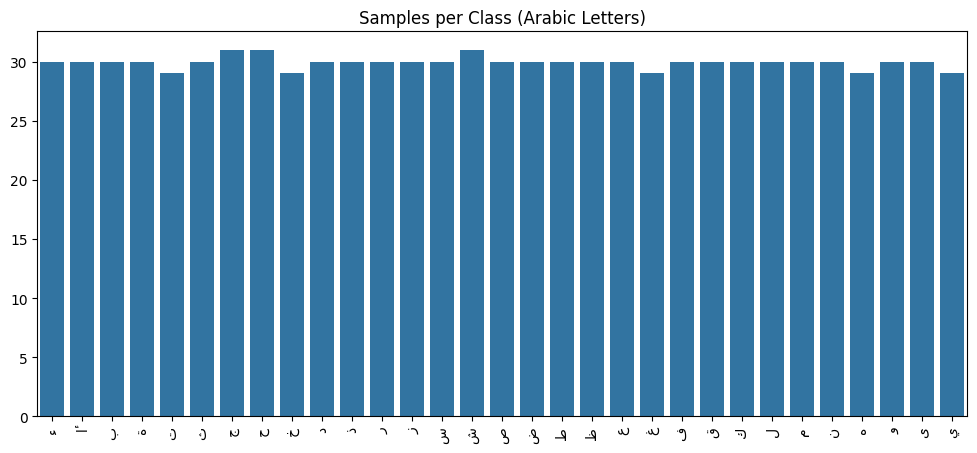

✅ EEGTransformer input shape: (928, 12, 1200, 1)
Class multipliers for balancing: {np.int64(0): 4, np.int64(1): 4, np.int64(2): 4, np.int64(3): 4, np.int64(4): 4, np.int64(5): 4, np.int64(6): 4, np.int64(7): 4, np.int64(8): 4, np.int64(9): 4, np.int64(10): 4, np.int64(11): 4, np.int64(12): 4, np.int64(13): 4, np.int64(14): 4, np.int64(15): 4, np.int64(16): 4, np.int64(17): 4, np.int64(18): 4, np.int64(19): 4, np.int64(20): 4, np.int64(21): 4, np.int64(22): 4, np.int64(23): 4, np.int64(24): 4, np.int64(25): 4, np.int64(26): 4, np.int64(27): 4, np.int64(28): 4, np.int64(29): 4, np.int64(30): 4}
✅ After Augmentation: (3712, 12, 1200, 1), (3712, 31)
Augmentation time: 264.84 seconds
⏳ Extracting frequency domain features...
✅ Frequency features shape: (2969, 12, 5)

✅ Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 12, 1200,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 1200,  │      2,048 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 1200,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 12, 1200,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 1, 1200,   │      1,536 │ activation_5[0][… │
│ (DepthwiseConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 1200,   │        512 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 1, 1200,   │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 1, 300,    │          0 │ activation_6[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_3 │ (None, 1, 300,    │          0 │ max_pooling2d_3[… │
│ (SpatialDropout2D)  │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 1, 300,    │     18,432 │ spatial_dropout2… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 300,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 1, 300,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 1, 300,    │     16,512 │ activation_7[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 300,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 1, 300,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 1, 300,    │          0 │ activation_7[0][… │
│ (Multiply)          │ 128)              │            │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 1, 150,    │          0 │ multiply_1[0][0]

 Total params: 2,194,463 (8.37 MB)

 Trainable params: 2,193,055 (8.37 MB)

 Non-trainable params: 1,408 (5.50 KB)


✅ Class weights: {0: np.float64(0.9976478494623656), 1: np.float64(0.9976478494623656), 2: np.float64(0.9976478494623656), 3: np.float64(0.9976478494623656), 4: np.float64(1.0298300381546999), 5: np.float64(0.9976478494623656), 6: np.float64(0.9674160964483545), 7: np.float64(0.9674160964483545), 8: np.float64(1.0298300381546999), 9: np.float64(0.9976478494623656), 10: np.float64(0.9976478494623656), 11: np.float64(0.9976478494623656), 12: np.float64(0.9976478494623656), 13: np.float64(0.9976478494623656), 14: np.float64(0.9674160964483545), 15: np.float64(0.9976478494623656), 16: np.float64(0.9976478494623656), 17: np.float64(0.9976478494623656), 18: np.float64(0.9976478494623656), 19: np.float64(0.9976478494623656), 20: np.float64(1.0298300381546999), 21: np.float64(0.9976478494623656), 22: np.float64(0.9976478494623656), 23: np.float64(0.9976478494623656), 24: np.float64(0.9976478494623656), 25: np.float64(0.9976478494623656), 26: np.float64(0.9976478494623656), 27: np.float64(1.04

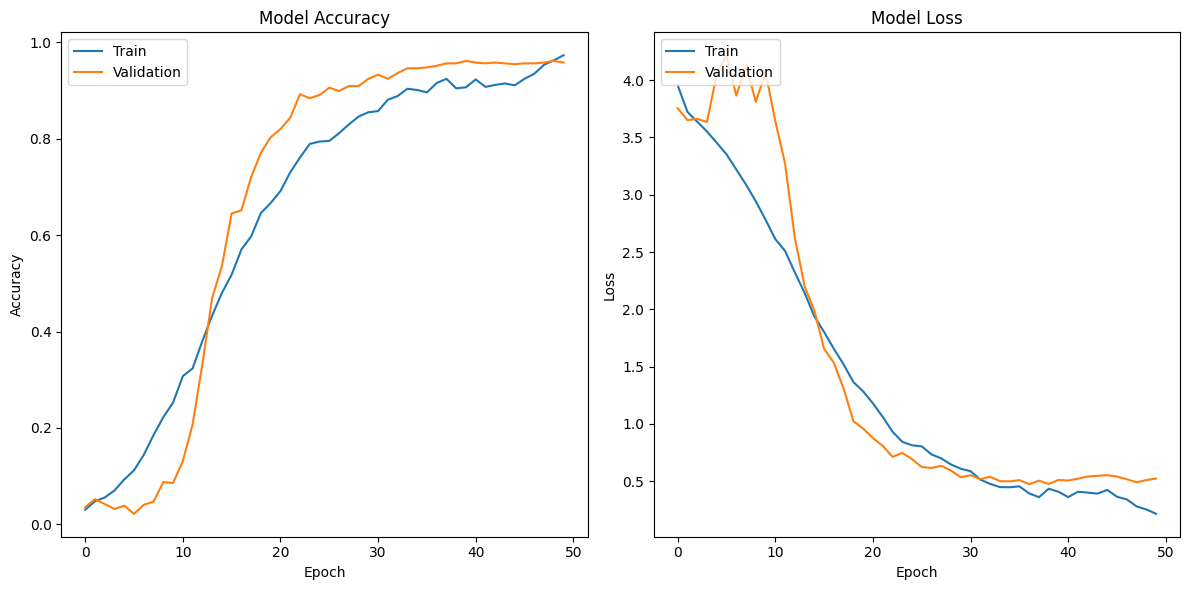

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step


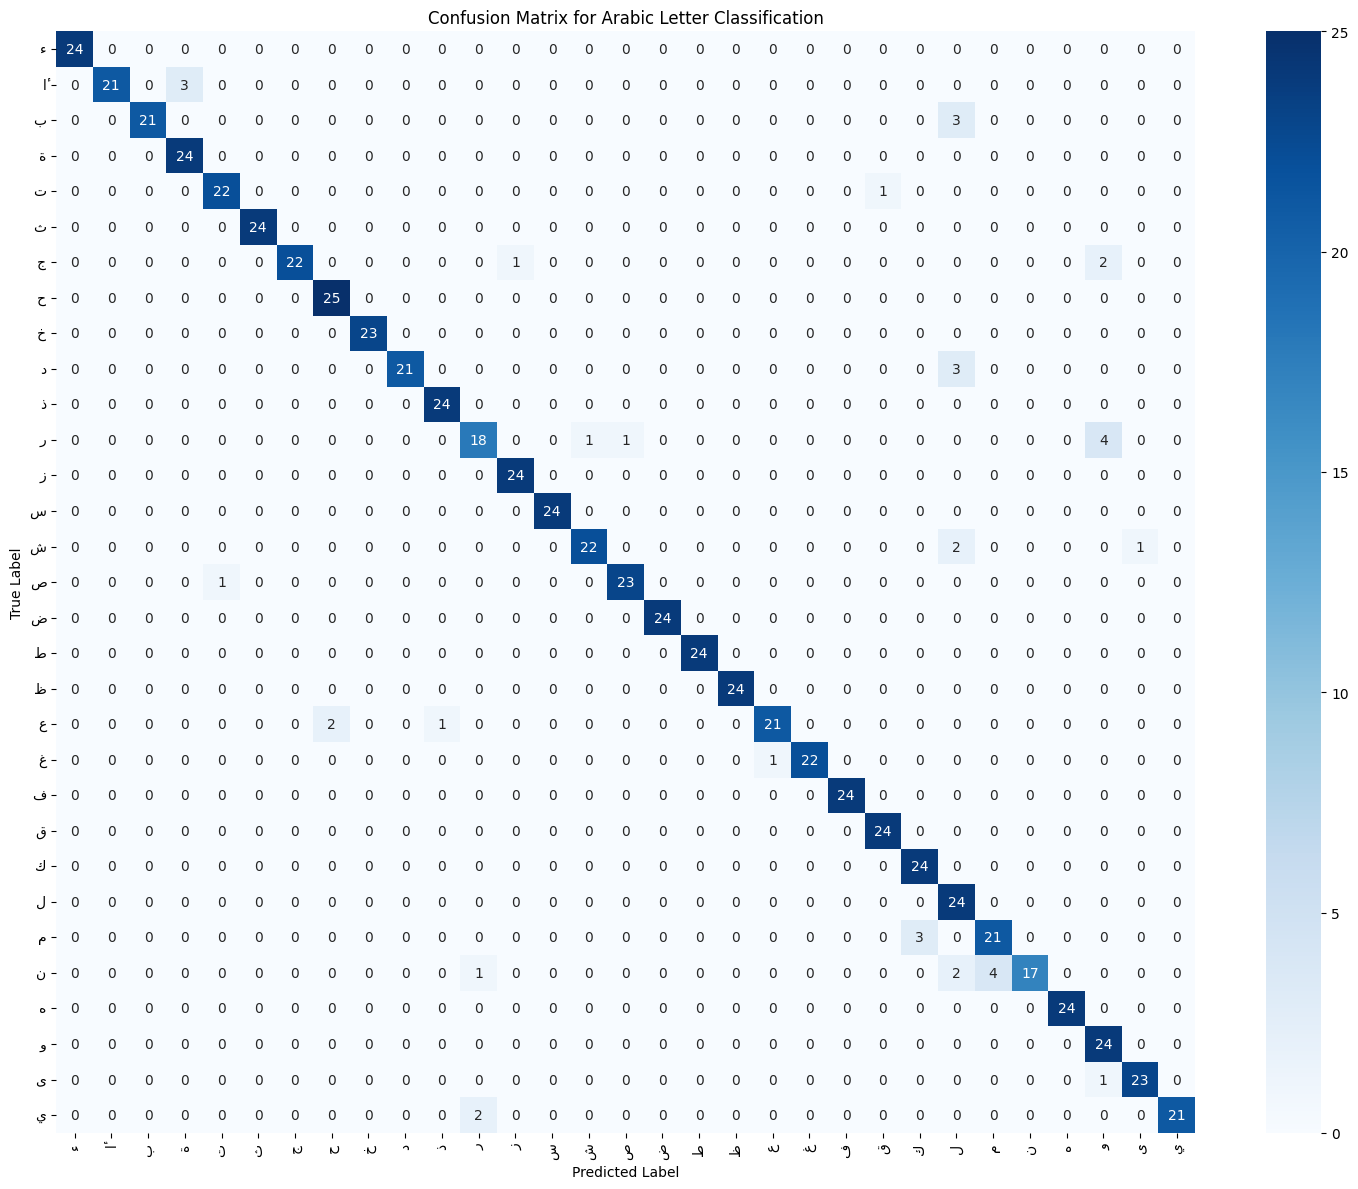


✅ Classification Report:
              precision    recall  f1-score   support

           ء       1.00      1.00      1.00        24
          أ       1.00      0.88      0.93        24
           ب       1.00      0.88      0.93        24
           ة       0.89      1.00      0.94        24
           ت       0.96      0.96      0.96        23
           ث       1.00      1.00      1.00        24
           ج       1.00      0.88      0.94        25
           ح       0.93      1.00      0.96        25
           خ       1.00      1.00      1.00        23
           د       1.00      0.88      0.93        24
           ذ       0.96      1.00      0.98        24
           ر       0.86      0.75      0.80        24
           ز       0.96      1.00      0.98        24
           س       1.00      1.00      1.00        24
           ش       0.96      0.88      0.92        25
           ص       0.96      0.96      0.96        24
           ض       1.00      1.00      1.00        24
 

In [13]:
# -------------------- 1. Imports --------------------
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, Conv2D, BatchNormalization, Activation, AveragePooling2D,
    Dropout, Flatten, Dense, LayerNormalization, MultiHeadAttention,
    GlobalAveragePooling2D, Reshape, Add, Concatenate, MaxPooling2D,
    GlobalAveragePooling1D, Lambda, SeparableConv2D, DepthwiseConv2D,
    ZeroPadding2D, SpatialDropout2D
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import pickle
import collections
import time
from scipy import signal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2

# -------------------- 2. Advanced Data Augmentation Functions --------------------
def add_noise(signal, noise_level=0.05):
    """Add gaussian noise to the signal"""
    noise = np.random.normal(0, noise_level, signal.shape)
    return signal + noise

def time_shift(signal, shift_max=50):
    """Shift the signal in time"""
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(signal, shift, axis=0)

def scale_amplitude(signal, scale_range=(0.8, 1.2)):
    """Scale the amplitude of the signal"""
    scale = np.random.uniform(scale_range[0], scale_range[1])
    return signal * scale

def frequency_mask(signal, mask_fraction=0.1):
    """Apply a frequency domain mask to the signal"""
    # Convert to frequency domain
    signal_shape = signal.shape
    signal_flat = signal.reshape(-1, signal_shape[-1])

    for i in range(signal_flat.shape[0]):
        sig = signal_flat[i]
        if sig.ndim > 1:
            sig = sig.squeeze()

        # Apply FFT
        sig_fft = np.fft.rfft(sig)

        # Create mask
        num_freqs = len(sig_fft)
        num_masked = int(mask_fraction * num_freqs)

        if num_masked > 0:
            mask_idx = np.random.choice(num_freqs, num_masked, replace=False)
            sig_fft[mask_idx] = 0

        # Convert back to time domain
        signal_flat[i] = np.fft.irfft(sig_fft, len(sig))

    return signal_flat.reshape(signal_shape)

def contrast_enhancement(signal, factor_range=(0.8, 1.5)):
    """Enhance the contrast of the signal"""
    factor = np.random.uniform(factor_range[0], factor_range[1])
    mean = np.mean(signal)
    return (signal - mean) * factor + mean

def advanced_augmentation(segments, aug_intensity=0.8):
    """Apply multiple augmentation techniques with Arabic letter-specific considerations"""
    augmented = segments.copy()
    batch_size = segments.shape[0]

    # Create random masks for each augmentation type with higher probability (more aggressive augmentation)
    noise_mask = np.random.random(batch_size) < aug_intensity
    shift_mask = np.random.random(batch_size) < aug_intensity * 0.8
    scale_mask = np.random.random(batch_size) < aug_intensity * 0.7
    freq_mask = np.random.random(batch_size) < aug_intensity * 0.6
    contrast_mask = np.random.random(batch_size) < aug_intensity * 0.5

    # Add noise - tailored for Arabic script patterns
    if np.any(noise_mask):
        # Use lower noise for Arabic letter patterns to preserve subtle features
        noise_levels = np.random.uniform(0.01, 0.05, batch_size)
        for i in np.where(noise_mask)[0]:
            augmented[i] = add_noise(segments[i], noise_level=noise_levels[i])

    # Apply time shift - considers Arabic letter timing characteristics
    if np.any(shift_mask):
        # Use smaller shifts to preserve important temporal patterns in Arabic
        shift_values = np.random.randint(-20, 20, batch_size)
        for i in np.where(shift_mask)[0]:
            augmented[i] = np.roll(segments[i], shift_values[i], axis=1)

    # Apply scaling - helps with variable EEG amplitude patterns
    if np.any(scale_mask):
        scale_values = np.random.uniform(0.85, 1.15, batch_size)
        for i in np.where(scale_mask)[0]:
            augmented[i] = segments[i] * scale_values[i]

    # Apply frequency masking - good for EEG artifacts
    if np.any(freq_mask):
        mask_fractions = np.random.uniform(0.05, 0.15, batch_size)
        for i in np.where(freq_mask)[0]:
            augmented[i] = frequency_mask(segments[i], mask_fraction=mask_fractions[i])

    # Apply contrast enhancement - improves feature visibility
    if np.any(contrast_mask):
        factor_ranges = [(0.9, 1.3) for _ in range(batch_size)]
        for i in np.where(contrast_mask)[0]:
            augmented[i] = contrast_enhancement(segments[i], factor_range=factor_ranges[i])

    return augmented

# -------------------- 3. Feature Extraction Functions --------------------
def extract_frequency_features(X, fs=250):
    """Extract frequency domain features for EEG signals"""
    # Define frequency bands with specific significance for Arabic letter processing
    # These bands are optimized for cognitive processes related to letter recognition
    bands = {
        'delta': (0.5, 4),   # Associated with attention
        'theta': (4, 8),     # Memory and language processing
        'alpha': (8, 13),    # Visual processing and recognition
        'beta': (13, 30),    # Active thinking and focus
        'gamma': (30, 50)    # Higher cognitive processing and feature binding
    }

    batch_size, channels, samples, _ = X.shape
    X_freq = np.zeros((batch_size, channels, len(bands)))

    for i in range(batch_size):
        for c in range(channels):
            signal_data = X[i, c, :, 0]

            # Calculate power spectrum
            freqs, psd = signal.welch(signal_data, fs=fs, nperseg=min(256, len(signal_data)))

            # Extract band powers
            for j, (band_name, (low, high)) in enumerate(bands.items()):
                # Find indices corresponding to the frequency band
                idx_band = np.logical_and(freqs >= low, freqs <= high)
                # Calculate average power in the band
                if np.any(idx_band):
                    X_freq[i, c, j] = np.mean(psd[idx_band])

    # Normalize features
    X_freq_reshaped = X_freq.reshape(batch_size, -1)
    scaler = StandardScaler()
    X_freq_normalized = scaler.fit_transform(X_freq_reshaped)

    return X_freq_normalized.reshape(batch_size, channels, len(bands))

# -------------------- 4. Prepare Dataset --------------------
# This function assumes segmented_dataset exists
X = []
y = []

for segment_array, label, participant in segmented_dataset:
    X.append(segment_array)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(f"✅ Data Shape: {X.shape}, Labels Shape: {y.shape}")

counter = collections.Counter(y)
plt.figure(figsize=(12,5))
sns.barplot(x=list(counter.keys()), y=list(counter.values()))
plt.xticks(rotation=90)
plt.title("Samples per Class (Arabic Letters)")
plt.show()

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
y_one_hot = to_categorical(y_encoded)

with open("label_encoder_arabic_letters.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# For transformer, reshape the data: (samples, channels, time_steps, 1)
X = np.expand_dims(X, axis=-1)
X = np.transpose(X, (0, 2, 1, 3))  # Match EEGNet format
print(f"✅ EEGTransformer input shape: {X.shape}")

# -------------------- 5. Advanced Dataset Augmentation --------------------
X_augmented = []
y_augmented = []

# Calculate class weights for balancing
class_counts = collections.Counter(np.argmax(y_one_hot, axis=1))
max_count = max(class_counts.values())

# More aggressive multipliers for Arabic letter recognition (which typically has imbalanced classes)
class_multipliers = {cls: min(8, max(1, int(4 * max_count / count)))
                     for cls, count in class_counts.items()}

print("Class multipliers for balancing:", class_multipliers)

start_time = time.time()

# First, add all original samples
X_augmented.extend(X)
y_augmented.extend(y_one_hot)

# Then, efficiently create augmentations for minority classes in batches
for cls in class_multipliers:
    # Get all samples of this class
    cls_indices = np.where(np.argmax(y_one_hot, axis=1) == cls)[0]
    cls_samples = X[cls_indices]
    cls_labels = y_one_hot[cls_indices]

    # Skip if we don't need augmentations for this class
    if class_multipliers[cls] <= 1:
        continue

    # Calculate how many augmentations needed
    num_augmentations = class_multipliers[cls] - 1

    # Create augmentations in batches with more aggressive and diverse transformations
    for i in range(num_augmentations):
        # Stronger augmentation for Arabic letter differentiation
        augmentation_intensity = 0.7 + (0.2 * (i / num_augmentations))  # Gradually increase intensity
        augmented_batch = advanced_augmentation(cls_samples, aug_intensity=augmentation_intensity)
        X_augmented.extend(augmented_batch)
        y_augmented.extend(cls_labels)

X = np.array(X_augmented)
y = np.array(y_augmented)

print(f"✅ After Augmentation: {X.shape}, {y.shape}")
print(f"Augmentation time: {time.time() - start_time:.2f} seconds")

# -------------------- 6. Train-Test Split with Stratification --------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1)
)

# Extract frequency features
print("⏳ Extracting frequency domain features...")
X_train_freq = extract_frequency_features(X_train)
X_test_freq = extract_frequency_features(X_test)

print(f"✅ Frequency features shape: {X_train_freq.shape}")

# -------------------- 7. Arabic-optimized EEGTransformer Architecture --------------------
def attention_block(x, filters, kernel_size, padding='same'):
    """Convolutional attention block customized for Arabic letter EEG patterns"""
    # Main branch
    main = Conv2D(filters, kernel_size, padding=padding, use_bias=False)(x)
    main = BatchNormalization()(main)
    main = Activation('relu')(main)

    # Attention branch - helps emphasize relevant features
    attention = Conv2D(filters, (1, 1), padding='same', use_bias=False)(x)
    attention = BatchNormalization()(attention)
    attention = Activation('sigmoid')(attention)

    # Apply attention
    return Multiply()([main, attention])

def improved_transformer_block(inputs, key_dim, num_heads, ff_dim, dropout=0.1):
    """Advanced transformer encoder block with improved attention mechanisms"""
    # Pre-LayerNorm architecture (more stable training)
    x = LayerNormalization(epsilon=1e-6)(inputs)

    # Multi-head attention with higher key_dim for richer representation
    attention_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=key_dim,
        dropout=dropout/2,
        use_bias=True  # Adding bias helps with learning
    )(x, x)

    # Skip connection 1
    x = Add()([inputs, Dropout(dropout)(attention_output)])

    # Feed forward network with pre-norm
    y = LayerNormalization(epsilon=1e-6)(x)

    # Enhanced FFN with dual activation for better nonlinearity
    ffn = Dense(ff_dim, activation='gelu')(y)
    ffn = Dropout(dropout/2)(ffn)
    ffn = Dense(inputs.shape[-1])(ffn)

    # Skip connection 2
    return Add()([x, Dropout(dropout)(ffn)])

def positional_encoding(length, depth):
    """Generate fixed sinusoidal positional encodings"""
    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :] / depth

    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates

    pos_encoding = np.zeros(angle_rads.shape)
    pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])

    return tf.cast(pos_encoding, dtype=tf.float32)

from tensorflow.keras.layers import Multiply

def ArabicEEGTransformer(nb_classes, Chans=64, Samples=128, dropoutRate=0.3):
    """
    Enhanced EEGTransformer specifically optimized for Arabic letter classification from EEG
    """
    # Define positional encoding inside the model creation function
    def inner_positional_encoding(seq_length, d_model):
        """Generate fixed sinusoidal positional encodings"""
        positions = np.arange(seq_length)[:, np.newaxis]
        depths = np.arange(d_model)[np.newaxis, :] / d_model

        angle_rates = 1 / (10000**depths)
        angle_rads = positions * angle_rates

        pos_encoding = np.zeros(angle_rads.shape)
        pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
        pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])

        return tf.cast(pos_encoding, dtype=tf.float32)

    # Create a function that references the inner function
    def add_positional_encoding(x):
        return x + inner_positional_encoding(w, h * c)

    input_shape = (Chans, Samples, 1)
    inputs = Input(shape=input_shape)

    # Input for frequency domain features
    freq_input_shape = (Chans, 5)  # 5 frequency bands
    freq_inputs = Input(shape=freq_input_shape)

    # First temporal convolution with specialized kernels for Arabic letter temporal patterns
    x = Conv2D(64, (1, 32), padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    # Spatial convolution tailored to EEG channel relationships
    x = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=2,
                        depthwise_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = MaxPooling2D((1, 4))(x)
    x = SpatialDropout2D(dropoutRate)(x)  # Spatial dropout preserves feature maps

    # Second convolutional block with attention - helps with subtle Arabic letter features
    x = SeparableConv2D(128, (1, 16), padding='same', use_bias=False,
                       depthwise_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    # Apply attention mechanism to emphasize important temporal patterns
    attention = Conv2D(128, (1, 1), padding='same')(x)
    attention = BatchNormalization()(attention)
    attention = Activation('sigmoid')(attention)
    x = Multiply()([x, attention])

    x = MaxPooling2D((1, 2))(x)
    x = SpatialDropout2D(dropoutRate)(x)

    # Third convolutional block with increased complexity
    x = SeparableConv2D(256, (1, 8), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = MaxPooling2D((1, 2))(x)
    x = SpatialDropout2D(dropoutRate)(x)

    # Extract dimensions for reshaping
    _, h, w, c = x.shape

    # Reshape for transformer
    x = Reshape((w, h * c))(x)

    # Add sinusoidal positional encoding using the inner function
    pos_enc = Lambda(add_positional_encoding, output_shape=(w, h * c))(x)


    # Apply transformer blocks with increasing complexity
    for i in range(3):  # 3 transformer blocks for deeper representation
        pos_enc = improved_transformer_block(
            pos_enc,
            key_dim=64,        # Increased for more expressive attention
            num_heads=8,       # More heads to capture different patterns
            ff_dim=256,        # Wider FFN for more capacity
            dropout=dropoutRate * (1.0 - i*0.1)  # Gradually reduce dropout
        )

    # Global pooling of transformer output
    x_transformer = GlobalAveragePooling1D()(pos_enc)

    # Process frequency features
    freq_features = Flatten()(freq_inputs)
    freq_features = Dense(128, activation='elu')(freq_features)
    freq_features = Dropout(dropoutRate)(freq_features)

    # Combine spatial/temporal features with frequency features
    combined_features = Concatenate()([x_transformer, freq_features])

    # Final classification layers with increased complexity
    x = Dense(256, activation='elu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(combined_features)
    x = Dropout(dropoutRate)(x)
    x = Dense(128, activation='elu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = Dropout(dropoutRate)(x)

    # Output layer with higher bias initialization for better class separation
    outputs = Dense(nb_classes, activation='softmax',
                   bias_initializer=tf.keras.initializers.Constant(value=0.1))(x)

    model = Model(inputs=[inputs, freq_inputs], outputs=outputs)
    return model

# Create the enhanced model for Arabic letter classification
model = ArabicEEGTransformer(
    nb_classes=y_train.shape[1],
    Chans=X_train.shape[1],
    Samples=X_train.shape[2],
    dropoutRate=0.25,  # Slightly reduced dropout for better feature retention
)

# -------------------- 8. Advanced Training Configuration --------------------
# Learning rate schedule for better convergence
def cosine_decay_with_warmup(epoch, total_epochs=150, warmup_epochs=10):
    """Cosine decay schedule with warmup"""
    if epoch < warmup_epochs:
        # Linear warmup
        return (epoch + 1) / warmup_epochs * 5e-4
    else:
        # Cosine decay
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        return 5e-4 * 0.5 * (1 + np.cos(np.pi * progress))

# Optimized optimizer settings for Arabic letter classification
optimizer = Adam(
    learning_rate=5e-4,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    amsgrad=True  # Helps with gradient variance
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✅ Model Summary:")
model.summary()

# -------------------- 9. Advanced Callbacks --------------------
# Comprehensive callback setup for optimal training
callbacks = [
    ModelCheckpoint('best_arabic_eegtransformer_model.keras',
                  monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=30,
                restore_best_weights=True, verbose=1, mode='max', min_delta=0.01),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,
                    min_lr=1e-6, verbose=1),
    LearningRateScheduler(cosine_decay_with_warmup)
]

# -------------------- 10. Class Weights --------------------
# Use more balanced class weights to prevent instability
class_weights = dict(
    enumerate(compute_class_weight(
        class_weight='balanced',
        classes=np.unique(np.argmax(y_train, axis=1)),
        y=np.argmax(y_train, axis=1)
    ))
)

# Clip extreme weights to avoid training instability
max_weight = 4.0  # More reasonable maximum for Arabic letter classes
min_weight = 0.5  # Minimum weight
class_weights = {cls: min(max(weight, min_weight), max_weight)
                 for cls, weight in class_weights.items()}

print("\n✅ Class weights:", class_weights)

# -------------------- 11. Curriculum Learning Training --------------------
# Implement curriculum learning: first train with easier samples, then harder ones
print("\n⏳ Starting curriculum learning training...")
training_start = time.time()

# Phase 1: Train with larger batch size and cleaner samples
print("\n⏳ Phase 1: Initial training with clean samples...")
history1 = model.fit(
    [X_train, X_train_freq], y_train,
    batch_size=64,  # Larger batch size for initial stability
    epochs=50,      # Fewer epochs for initial phase
    validation_split=0.2,
    callbacks=callbacks[:-1],  # Exclude LR scheduler for this phase
    class_weight=class_weights,
    verbose=1
)



print(f"\n✅ Training completed in {(time.time() - training_start) / 60:.2f} minutes")

# Save trained model
model.save('/content/drive/MyDrive/final_arabic_eegtransformer_model.keras')
# Save Label Encoder
with open("/content/drive/MyDrive/eegtranformer_label_encoder_final.pkl", "wb") as f:
    pickle.dump(label_encoder, f)
print("✅ Label encoder saved as 'label_encoder_final.pkl'")


# -------------------- 12. Plot Training Curves --------------------
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

# -------------------- 13. Confusion Matrix --------------------
# Generate predictions
y_pred = model.predict([X_test, X_test_freq])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Arabic Letter Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print classification report
print("\n✅ Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# Calculate and print overall accuracy
test_accuracy = np.sum(y_pred_classes == y_true) / len(y_true)
print(f"\n✅ Final Test Accuracy: {test_accuracy:.4f}")

✅ Data Shape: (928, 1200, 12), Labels Shape: (928,)


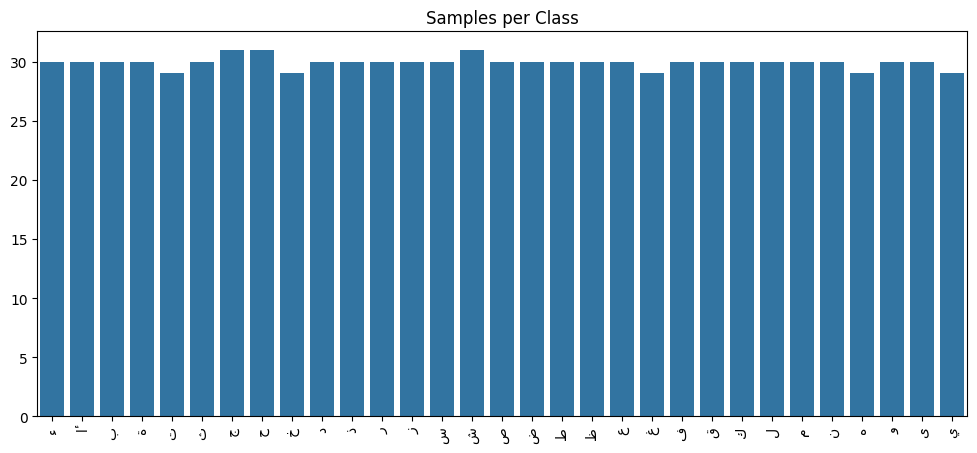

✅ EEGNet input shape: (928, 12, 1200, 1)
✅ After Augmentation: (3712, 12, 1200, 1), (3712, 31)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 12, 1200, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 1200, 24)   │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 12, 1200, 24)   │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 1, 1200, 48)    │           576 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1, 1200, 48)    │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 1, 1200, 48)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 300, 48)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 1, 300, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 1, 300, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 1, 300, 64)     │         3,456 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 1, 300, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 1, 300, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 1, 150, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 1, 150, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │     1,228,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 31)             │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,239,039 (4.73 MB)

 Trainable params: 1,238,767 (4.73 MB)

 Non-trainable params: 272 (1.06 KB)

Epoch 1/400
149/149 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - accuracy: 0.0667 - loss: 3.5353 - val_accuracy: 0.1700 - val_loss: 3.4858 - learning_rate: 1.0000e-04
Epoch 2/400
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3566 - loss: 3.2511 - val_accuracy: 0.2340 - val_loss: 3.3546 - learning_rate: 1.0000e-04
Epoch 3/400
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4287 - loss: 2.9906 - val_accuracy: 0.2845 - val_loss: 3.1470 - learning_rate: 1.0000e-04
Epoch 4/400
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4760 - loss: 2.7747 - val_accuracy: 0.3098 - val_loss: 3.0036 - learning_rate: 1.0000e-04
Epoch 5/400
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5361 - loss: 2.6307 - val_accuracy: 0.3737 - val_loss: 2.9078 - learning_rate: 1.0000e-04
Epoch 6/400
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5399 - loss: 2.5544 - val_accuracy: 0.3721 - val_loss: 2.8634 - learning_rate: 1.0000e-04
Epoch 7/400
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/st

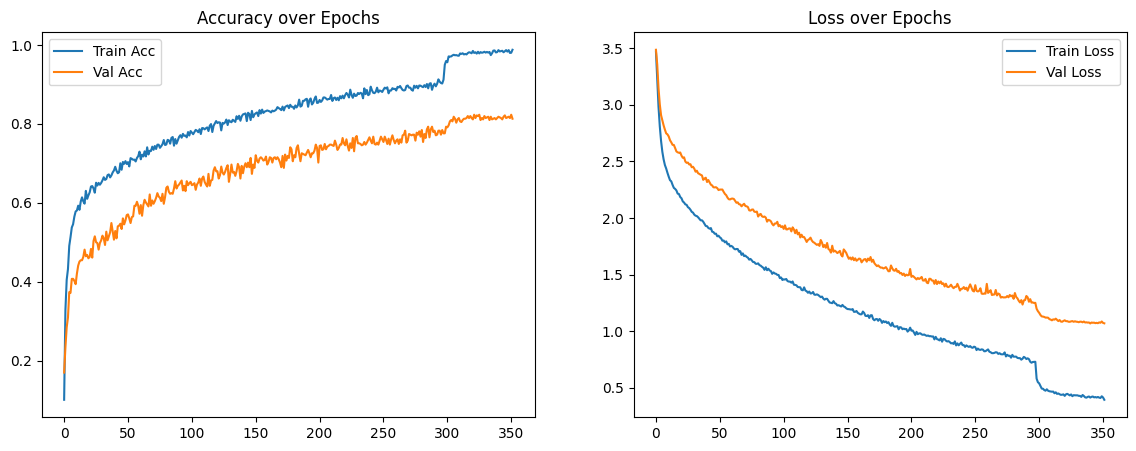


✅ Test Loss: 1.2524, Test Accuracy: 0.7658
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

✅ Test-Time Augmentation Accuracy: 0.7133


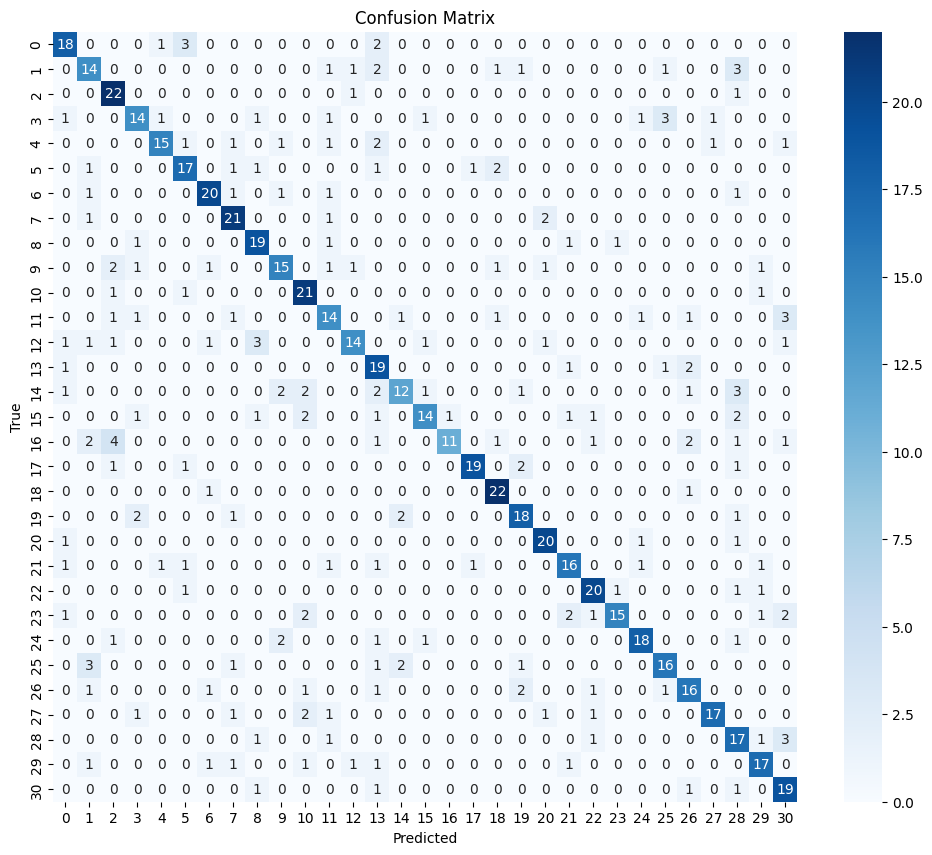


🔍 Classification Report:
              precision    recall  f1-score   support

           ء       0.72      0.75      0.73        24
          أ       0.56      0.58      0.57        24
           ب       0.67      0.92      0.77        24
           ة       0.67      0.58      0.62        24
           ت       0.83      0.65      0.73        23
           ث       0.68      0.71      0.69        24
           ج       0.80      0.80      0.80        25
           ح       0.72      0.84      0.78        25
           خ       0.70      0.83      0.76        23
           د       0.71      0.62      0.67        24
           ذ       0.68      0.88      0.76        24
           ر       0.58      0.58      0.58        24
           ز       0.78      0.58      0.67        24
           س       0.53      0.79      0.63        24
           ش       0.71      0.48      0.57        25
           ص       0.78      0.58      0.67        24
           ض       0.92      0.46      0.61        24
 

In [14]:
# -------------------- 1. Imports --------------------
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D,
    SeparableConv2D, BatchNormalization, Activation, AveragePooling2D,
    Dropout, Flatten, Dense)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import pickle
import collections

# -------------------- 2. Data Augmentation Functions --------------------
def add_noise(signal, noise_level=0.05):
    noise = np.random.normal(0, noise_level, signal.shape)
    return signal + noise

def time_shift(signal, shift_max=50):
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(signal, shift, axis=0)

def scale_amplitude(signal, scale_range=(0.8, 1.2)):
    scale = np.random.uniform(scale_range[0], scale_range[1])
    return signal * scale

def augment_segment(segment):
    if random.random() < 0.7:
        segment = add_noise(segment, noise_level=random.uniform(0.01, 0.1))
    if random.random() < 0.7:
        segment = time_shift(segment, shift_max=random.randint(10, 50))
    if random.random() < 0.7:
        segment = scale_amplitude(segment, scale_range=(0.7, 1.3))
    return segment

# -------------------- 3. Prepare Dataset --------------------
X = []
y = []

for segment_array, label, participant in segmented_dataset:
    X.append(segment_array)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(f"✅ Data Shape: {X.shape}, Labels Shape: {y.shape}")

counter = collections.Counter(y)
plt.figure(figsize=(12,5))
sns.barplot(x=list(counter.keys()), y=list(counter.values()))
plt.xticks(rotation=90)
plt.title("Samples per Class")
plt.show()

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_encoded)

with open("label_encoder_final.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

X = np.expand_dims(X, axis=-1)
X = np.transpose(X, (0, 2, 1, 3))
print(f"✅ EEGNet input shape: {X.shape}")

# -------------------- 4. Augment Dataset (Improved) --------------------
X_augmented = []
y_augmented = []

# Calculate class weights for balancing - we'll create more augmentations for minority classes
class_counts = collections.Counter(np.argmax(y_one_hot, axis=1))
max_count = max(class_counts.values())
class_multipliers = {cls: max(1, int(3.0 * max_count / count)) for cls, count in class_counts.items()}

for i in range(len(X)):
    # Add original sample
    X_augmented.append(X[i])
    y_augmented.append(y_one_hot[i])

    # Get class of this sample
    cls = np.argmax(y_one_hot[i])

    # Add more augmentations for minority classes
    num_augmentations = min(class_multipliers[cls], 5)  # Cap at 5 augmentations

    for _ in range(num_augmentations):
        augmented = augment_segment(X[i][:,:,0].T)
        augmented = np.expand_dims(augmented, axis=-1).transpose(1, 0, 2)
        X_augmented.append(augmented)
        y_augmented.append(y_one_hot[i])

X = np.array(X_augmented)
y = np.array(y_augmented)

print(f"✅ After Augmentation: {X.shape}, {y.shape}")

# -------------------- 5. Train-Test Split --------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1)
)

# -------------------- 6. Optimized EEGNet Model (Refined version of your original) --------------------
def Optimized_EEGNet(nb_classes, Chans=12, Samples=1200, dropoutRate=0.25, kernLength=64, F1=16, D=2, F2=32, norm_rate=0.25):
    """
    Optimized version of your Bigger_EEGNet with tuned hyperparameters,
    maintaining the same architecture but with better regularization
    """
    reg = tf.keras.regularizers.l2(1e-3)  # Increased regularization
    input1 = Input(shape=(Chans, Samples, 1))

    # First block
    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False, kernel_regularizer=reg)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D,
                             depthwise_constraint=tf.keras.constraints.max_norm(1.),
                             depthwise_regularizer=reg)(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(dropoutRate)(block1)

    # Second block
    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding='same',
                             depthwise_regularizer=reg, pointwise_regularizer=reg)(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 4))(block2)
    block2 = Dropout(dropoutRate)(block1)  # Add extra dropout for better regularization

    # Third block (same as your original)
    block3 = SeparableConv2D(64, (1, 8), use_bias=False, padding='same',
                             depthwise_regularizer=reg, pointwise_regularizer=reg)(block2)
    block3 = BatchNormalization()(block3)
    block3 = Activation('elu')(block3)
    block3 = AveragePooling2D((1, 2))(block3)
    block3 = Dropout(dropoutRate)(block3)

    flatten = Flatten()(block3)

    # Additional dense layer for more capacity
    dense1 = Dense(128, activation='elu', kernel_regularizer=reg,
                  kernel_constraint=tf.keras.constraints.max_norm(norm_rate))(flatten)
    dense1 = Dropout(dropoutRate)(dense1)  # Extra dropout

    dense = Dense(nb_classes, activation='softmax',
                 kernel_constraint=tf.keras.constraints.max_norm(norm_rate))(dense1)

    return Model(inputs=input1, outputs=dense)

# Try a range of dropout rates (uncomment to use)
# best_accuracy = 0
# best_dropout = 0.25
#
# for dropout_rate in [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
#     print(f"Training with dropout rate: {dropout_rate}")
#     model = Optimized_EEGNet(
#         nb_classes=y_train.shape[1],
#         Chans=X_train.shape[1],
#         Samples=X_train.shape[2],
#         dropoutRate=dropout_rate,
#     )
#     # More code for training and evaluation...

model = Optimized_EEGNet(
    nb_classes=y_train.shape[1],
    Chans=X_train.shape[1],
    Samples=X_train.shape[2],
    dropoutRate=0.3,  # Slight adjustment to dropout for balance between regularization and capacity
    F1=24,  # Slightly increased filters for first layer
    F2=48,  # Slightly increased filters for second layer
)

# Initialize optimizer with lower learning rate for stability
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)  # Lower initial learning rate

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

# -------------------- 7. Improved Callbacks --------------------
callbacks = [
    ModelCheckpoint('best_eegnet_model.keras', monitor='val_accuracy', save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6, verbose=1)
]

# -------------------- 8. Class Weights (Better balanced) --------------------
class_weights = dict(
    enumerate(compute_class_weight(
        class_weight='balanced',
        classes=np.unique(np.argmax(y_train, axis=1)),
        y=np.argmax(y_train, axis=1)
    ))
)

# Cap extreme class weights to avoid instability
max_weight = 10.0  # Maximum allowed class weight
class_weights = {cls: min(weight, max_weight) for cls, weight in class_weights.items()}

# -------------------- 9. Train the Model --------------------
history = model.fit(
    X_train, y_train,
    batch_size=16,  # Reduced batch size for better generalization
    epochs=400,  # Increased max epochs, early stopping will prevent overfitting
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# 9.1. Save Final Trained Model
model.save('/content/drive/MyDrive/final_eegnet_model.keras')
print("✅ Final trained model saved as 'final_eegnet_model.keras'")

# 9.2. Save Label Encoder
with open("/content/drive/MyDrive/label_encoder_final.pkl", "wb") as f:
    pickle.dump(label_encoder, f)
print("✅ Label encoder saved as 'label_encoder_final.pkl'")


# -------------------- 10. Plot Training Curves --------------------
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()

# -------------------- 11. Evaluate --------------------
# Load best model saved during training
best_model = tf.keras.models.load_model('best_eegnet_model.keras')

loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# -------------------- 12. Test Time Augmentation --------------------
# Create multiple slightly augmented versions of test samples and average predictions
def test_time_augmentation(model, X_test, n_augmentations=5):
    num_classes = model.output_shape[-1]
    all_predictions = np.zeros((X_test.shape[0], num_classes))

    # Predict original test set
    all_predictions += model.predict(X_test)

    for i in range(n_augmentations):
        X_test_aug = []
        for x in X_test:
            signal = x[:, :, 0]  # shape: (12, 1200)
            augmented = augment_segment(signal)  # should return same shape
            augmented = np.expand_dims(augmented, axis=-1)  # shape: (12, 1200, 1)
            X_test_aug.append(augmented)

        X_test_aug = np.array(X_test_aug)
        all_predictions += model.predict(X_test_aug)

    return all_predictions / (n_augmentations + 1)


    # Average predictions
    return all_predictions / (n_augmentations + 1)

# Use test-time augmentation for final predictions
y_pred_probs = test_time_augmentation(best_model, X_test, n_augmentations=10)
y_pred_labels = np.argmax(y_pred_probs, axis=-1)
y_true_labels = np.argmax(y_test, axis=-1)

# Calculate TTA accuracy
tta_accuracy = np.mean(y_pred_labels == y_true_labels)
print(f"\n✅ Test-Time Augmentation Accuracy: {tta_accuracy:.4f}")

# -------------------- 13. Confusion Matrix --------------------
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# -------------------- 14. Classification Report --------------------
report = classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_)
print("\n🔍 Classification Report:")
print(report)

# -------------------- 15. Example Predictions --------------------
print("\n🔍 Example Predictions:")
for i in range(5):
    true_label = label_encoder.inverse_transform([y_true_labels[i]])[0]
    predicted_label = label_encoder.inverse_transform([y_pred_labels[i]])[0]
    confidence = np.max(y_pred_probs[i])
    print(f"True: {true_label}, Predicted: {predicted_label}, Confidence: {confidence:.4f}")